# Loading Libraries

In [1]:
# Buidling the habit :)
import warnings
warnings.simplefilter("ignore")

In [2]:
# !pip install -U pillow==6.2.2

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
import h5py # to handle weights
import os, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image

import tensorflow.keras as keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications

from IPython.display import Image, display
np.random.seed(387)

# Scraping

In [5]:
''' 
I will also be using 1200 images for each set. The cat images I fetched
from Kaggle Dataset and the Pikachu/Kanye images were fetched using the Bing
Image Downloader Library.

Once I had the images, I cleaned out some of the gifs and moved them around to
create a directory structure with test train and validation data with 
corresponding folders wherever required.

For each class I have split it to Train:Val:Test at 900:250:50

The dataset will be attached in my submission.
'''

# !pip install bing-image-downloader

# from bing_image_downloader import downloader

# downloader.download("Kanye West Pictures", limit=350,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)
# downloader.download("Kanye West", limit=600,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)
# downloader.download("Kanye West Images", limit=400,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)
# 
# downloader.download("Pikachu Cute", limit=120, output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=120)
# downloader.download("Pikachu", limit=186,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=120)
# downloader.download("Pikachu happy", limit=26,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=120)

' \nI will also be using 1200 images for each set. The cat images I fetched\nfrom Kaggle Dataset and the Pikachu/Kanye images were fetched using the Bing\nImage Downloader Library.\n\nOnce I had the images, I cleaned out some of the gifs and moved them around to\ncreate a directory structure with test train and validation data with \ncorresponding folders wherever required.\n\nFor each class I have split it to Train:Val:Test at 900:250:50\n\nThe dataset will be attached in my submission.\n'

In [6]:
# cd dataset
# /content/dataset/Pikachu

In [7]:
# !cp -r '/content/dataset/dataset/Kanye West Pictures' "/content/drive/My Drive"
# !cp -r '/content/dataset/Pikachu Images' "/content/drive/My Drive"

In [8]:
# import os
# import shutil

# source1 = '/content/drive/My Drive/Kanye West Images/'
# source2 = '/content/drive/My Drive/Kanye West Pictures/'
# destination = '/content/drive/My Drive/Kanye West/'
  
# allfiles1 = os.listdir(source1)
# allfiles2 = os.listdir(source2)
  
# for f in allfiles1:
#     shutil.move(source1 + f, destination + f + "_new1")

# for f in allfiles2:
#     shutil.move(source2 + f, destination + f + "_new2")

In [9]:
# import os, glob
# for filename in glob.glob("/content/drive/My Drive/TRAIN/Pikachu/*"):
#     os.remove(filename)

In [10]:
# import os
# import shutil
# source1 = '/content/dataset/dataset/Pikachu happy/'
# destination = '/content/drive/My Drive/TRAIN/Pikachu/'
  
# allfiles1 = os.listdir(source1)
  
# for f in allfiles1:
#     shutil.move(source1 + f, destination +"u"+ f)

In [11]:
import os
import shutil

source1 = '/content/drive/My Drive/TRAIN/Kanye/'
source2 = '/content/drive/My Drive/TRAIN/Pikachu/'
source3 = '/content/drive/My Drive/TRAIN/Cat/'

destination0 = '/content/drive/My Drive/TEST/Tester/'

source11 = '/content/drive/My Drive/VAL/Kanye/'
source21 = '/content/drive/My Drive/VAL/Pikachu/'
source31 = '/content/drive/My Drive/VAL/Cat/'

print('pre split')
print(len(os.listdir(source1)), len(os.listdir(source2)), len(os.listdir(source3)))

# for f in os.listdir(source1)[:250]:
#     shutil.move(source1 + f, source11 + f)

# for f in os.listdir(source2)[:250]:
#     shutil.move(source2 + f, source21 + f)

# # for f in os.listdir(source3)[:250]:
# #     shutil.move(source3 + f, source31 + f)


# for f in os.listdir(source1)[:50]:
#     shutil.move(source1 + f, destination0 + f)

# for f in os.listdir(source2)[:50]:
#     shutil.move(source2 + f, destination0 + f)

# # for f in os.listdir(source3)[:50]:
# #     shutil.move(source3 + f, destination0 + f)

print('\npost split')
print('TRAIN:', len(os.listdir(source1)), len(os.listdir(source2)), len(os.listdir(source3)))
print('VAL:', len(os.listdir(source11)), len(os.listdir(source21)), len(os.listdir(source31)))
print('TEST:', len(os.listdir(destination0)))

pre split
900 900 900

post split
TRAIN: 900 900 900
VAL: 250 250 250
TEST: 150


# Modelling

In [12]:
TRAIN_DIR = '/content/drive/My Drive/TRAIN/'
VAL_DIR = '/content/drive/My Drive/VAL/'
TEST_DIR = '/content/drive/My Drive/TEST/'

img_width, img_height = 150, 150

n_train_samples = 2700
n_validation_samples = 750
n_epoch = 20
n_test_samples = 150

In [13]:
def save_bottleneck_features():
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height, 3))
    
    # documentation: https://keras.io/applications/#vgg16
    
    print('TensorFlow VGG16 model architecture loaded')
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small
    # input_shape with channels last for tensorflow
    
    # Our original images consist in RGB coefficients in the 0-255 interval, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')
    
        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=1,
            class_mode='categorical', # this means our generator will only yield batches of data, no labels
            shuffle=False)   # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        
        
        features = model.predict_generator(generator, n_samples, verbose=True)
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')


print('This has been done before the lecture! Takes 5+ mins to run.')
save_bottleneck_features()

This has been done before the lecture! Takes 5+ mins to run.
58900480/58889256 [==============================] - 2s 0us/step
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 150 images belonging to 1 classes.
150/150 [==============================] - 23s 107ms/step
Generate train image features
Found 2700 images belonging to 3 classes.
2700/2700 [==============================] - 873s 323ms/step
Generate validation image features
Found 750 images belonging to 3 classes.
750/750 [==============================] - 251s 336ms/step

Done! Bottleneck features have been saved


In [14]:
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height),
                                batch_size=32, class_mode='categorical', shuffle=False)
# Since we require categorical classification
val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 750 images belonging to 3 classes.

Classifications:
 {'Cat': 0, 'Kanye': 1, 'Pikachu': 2}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [15]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

def train_model():
    train_data = np.load('features_train.npy')
    # One hot encoding for categorical_crossentropy
    train_labels = np.array([[1,0,0]] * (n_train_samples // 3) + [[0,1,0]] * (n_train_samples // 3)+ [[0,0,1]] * (n_train_samples // 3))

    validation_data = np.load('features_validation.npy')
    validation_labels = np.array([[1,0,0]] * (n_validation_samples // 3) + [[0,1,0]] * (n_validation_samples // 3)+ [[0,0,1]] * (n_validation_samples // 3))

    print(train_data.shape[1:])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    '''
    #We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    #To go with it we will also use the binary_crossentropy loss to train our model.

    '''
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    MODEL_WEIGHTS_FILE = 'vgg16-best-weights.h5'
    callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_accuracy', verbose=1, save_best_only=True)]
    
    history = model.fit(train_data, train_labels, verbose=1, \
                        epochs=20, batch_size=32, \
                        validation_data=(validation_data, validation_labels),
                        callbacks=callbacks)

    # Save weights to disk
    # Save model architecture to disk
    model_json = model.to_json()
    with open("mod_appendix.json", "w") as json_file: # save model
        json_file.write(model_json)
    
    # Save model weights
    model.save_weights("catvsdogs_VGG16_pretrained_tf_top.h5") # save weights
    print("Saved model to disk")
    print('Done!')
    
    return(history)
    
history = train_model()

(4, 4, 512)
Epoch 1/20
75/85 [=========================>....] - ETA: 0s - loss: 0.8467 - accuracy: 0.7754
Epoch 1: val_accuracy improved from -inf to 0.88133, saving model to vgg16-best-weights.h5
85/85 [==============================] - 2s 6ms/step - loss: 0.7955 - accuracy: 0.7848 - val_loss: 0.2958 - val_accuracy: 0.8813
Epoch 2/20
74/85 [=========================>....] - ETA: 0s - loss: 0.3106 - accuracy: 0.8872
Epoch 2: val_accuracy did not improve from 0.88133
85/85 [==============================] - 0s 4ms/step - loss: 0.3071 - accuracy: 0.8896 - val_loss: 0.3448 - val_accuracy: 0.8747
Epoch 3/20
76/85 [=========================>....] - ETA: 0s - loss: 0.2356 - accuracy: 0.9165
Epoch 3: val_accuracy improved from 0.88133 to 0.92267, saving model to vgg16-best-weights.h5
85/85 [==============================] - 0s 4ms/step - loss: 0.2395 - accuracy: 0.9152 - val_loss: 0.2144 - val_accuracy: 0.9227
Epoch 4/20
73/85 [========================>.....] - ETA: 0s - loss: 0.1898 - accura

In [16]:
history.model.load_weights('vgg16-best-weights.h5')

In [17]:
model = history.model

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


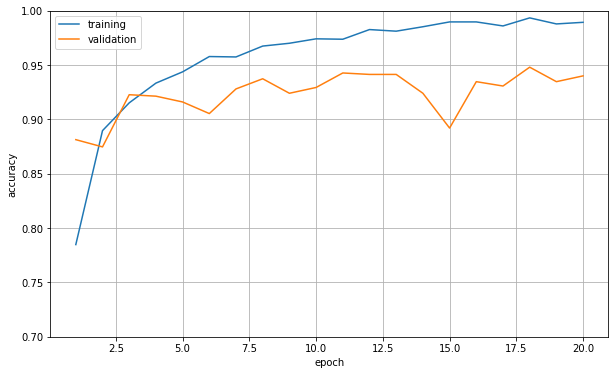

In [19]:
acc = pd.DataFrame({'epoch': range(1,n_epoch+1),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.7,1.0]);

In [20]:
validation_data = np.load('features_validation.npy')

val_pred_class=model.predict(validation_data) 
classes_x=np.argmax(val_pred_class,axis=1)

print('Accuracy on validation set: ',np.mean(classes_x.ravel()==val_labels)*100,'%')

Accuracy on validation set:  94.8 %


In [21]:
from PIL import Image

test_data = np.load('features_test.npy')
test_pred_class=model.predict(test_data) 
classes_x1=np.argmax(test_pred_class,axis=1)
test_images = [TEST_DIR+'Tester/'+img for img in sorted(os.listdir(TEST_DIR+'Tester/'))]

def read_image(file_path):
    im = np.array(Image.open(file_path))
    return im

def plot_pic(img):
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



I think this is a KANYE with 100.0% probability


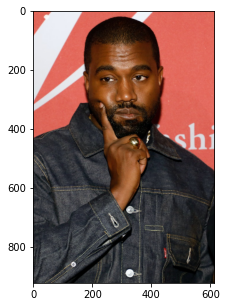



I think this is a CAT with 99.99989% probability


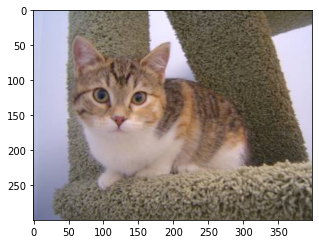



I think this is a CAT with 100.0% probability


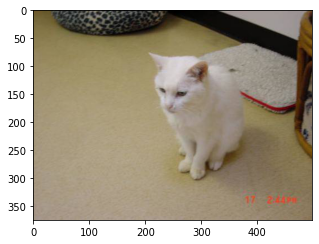



I think this is a PIKACHU with 100.0% probability


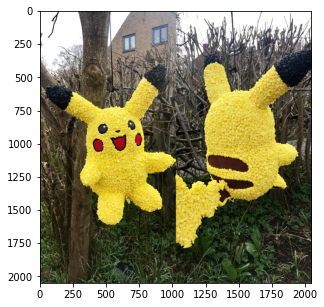



I think this is a CAT with 100.0% probability


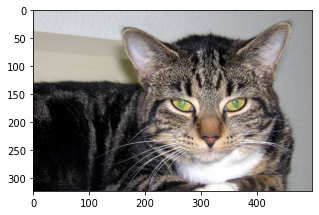



I think this is a KANYE with 99.99278% probability


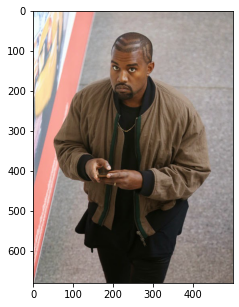



I think this is a KANYE with 100.0% probability


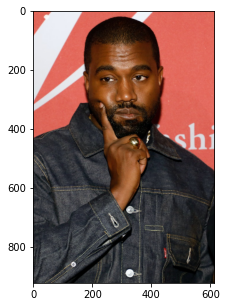



I think this is a PIKACHU with 100.0% probability


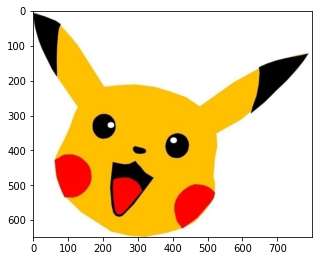



I think this is a CAT with 100.0% probability


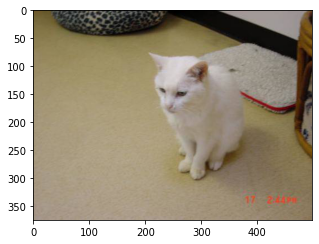



I think this is a KANYE with 99.59677% probability


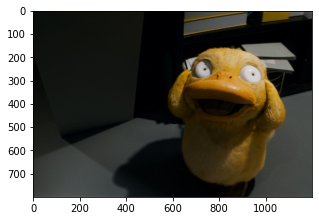



I think this is a KANYE with 100.0% probability


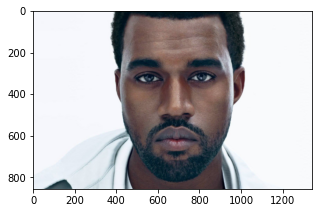



I think this is a CAT with 100.0% probability


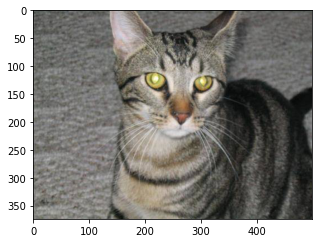



I think this is a PIKACHU with 100.0% probability


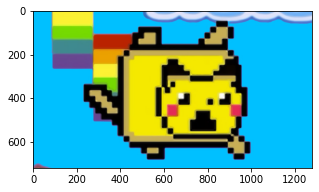



I think this is a PIKACHU with 100.0% probability


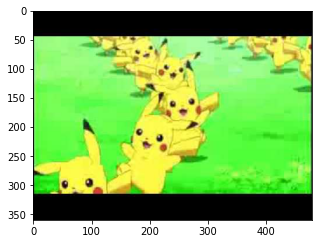



I think this is a KANYE with 99.73109% probability


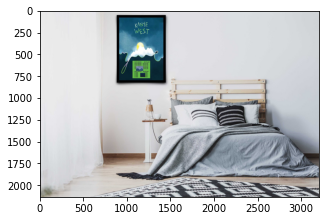



I think this is a KANYE with 100.0% probability


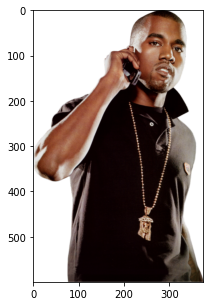



I think this is a KANYE with 100.0% probability


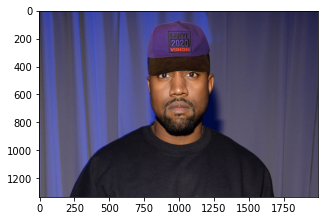



I think this is a PIKACHU with 99.78201% probability


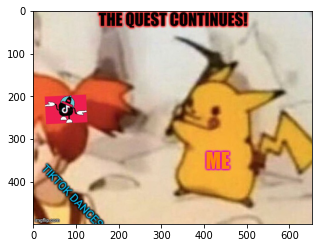



I think this is a KANYE with 100.0% probability


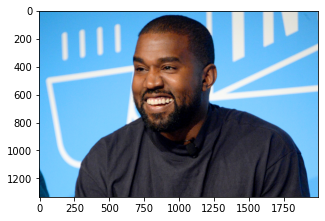



I think this is a PIKACHU with 100.0% probability


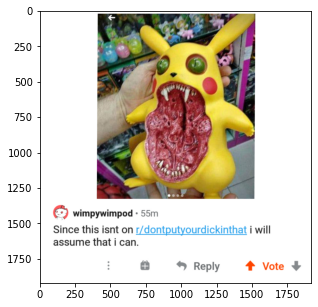



I think this is a CAT with 100.0% probability


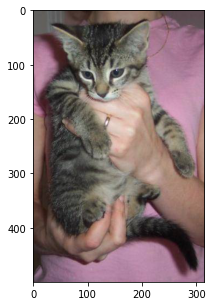



I think this is a CAT with 100.0% probability


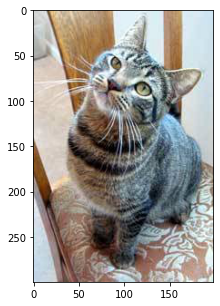



I think this is a KANYE with 99.99996% probability


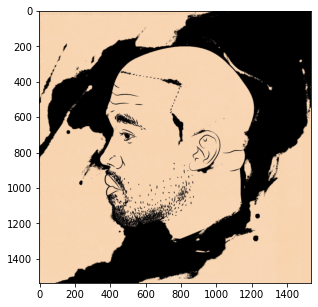



I think this is a PIKACHU with 100.0% probability


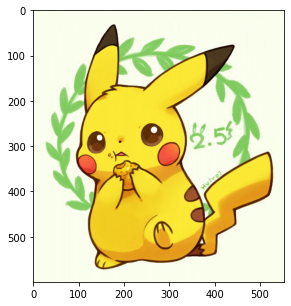



I think this is a PIKACHU with 100.0% probability


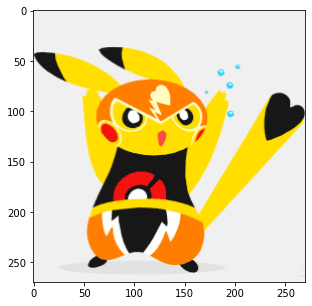



I think this is a CAT with 100.0% probability


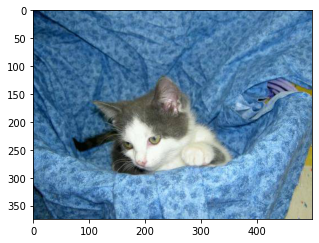



I think this is a CAT with 99.99998% probability


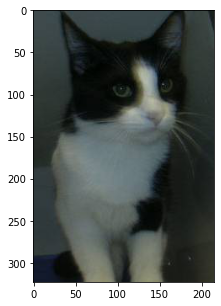



I think this is a PIKACHU with 100.0% probability


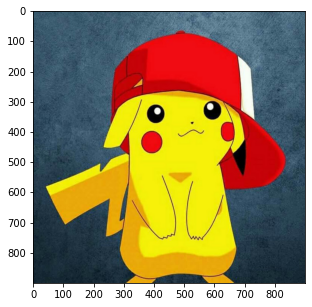



I think this is a CAT with 100.0% probability




I think this is a KANYE with 100.0% probability




I think this is a CAT with 99.99987% probability


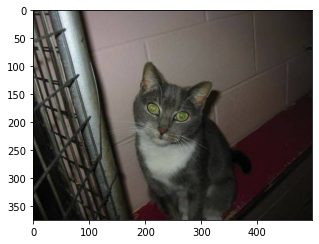



I think this is a CAT with 100.0% probability


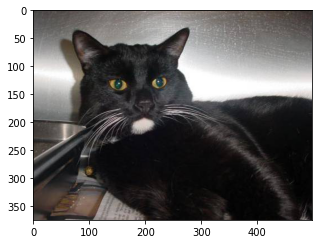



I think this is a CAT with 100.0% probability


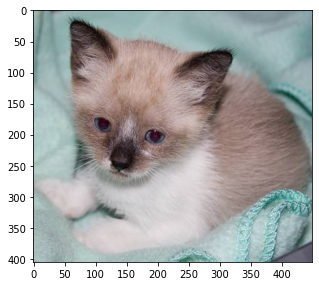



I think this is a KANYE with 100.0% probability


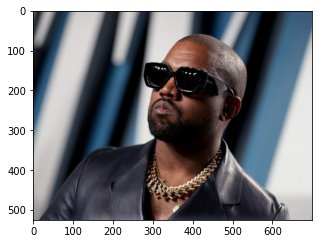



I think this is a KANYE with 99.98769% probability


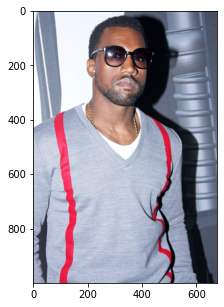



I think this is a KANYE with 100.0% probability


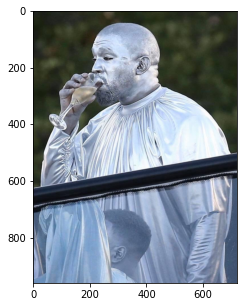



I think this is a KANYE with 100.0% probability


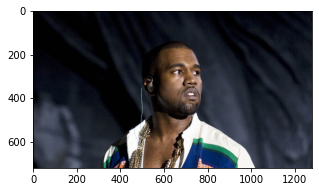



I think this is a KANYE with 100.0% probability


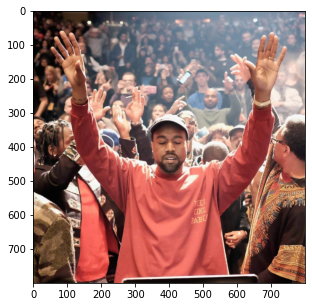



I think this is a CAT with 100.0% probability




I think this is a CAT with 99.75089% probability


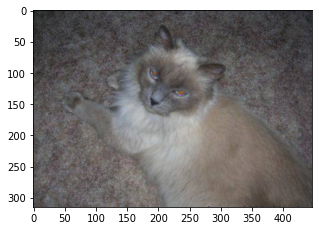

In [22]:
def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        if test_images[idx]=='./data/test/catvdog/.DS_Store' or '.ipynb_checkpoints' in test_images[idx]:
            continue
        class_pred = mod.predict(test_data,verbose=0)[idx]
        predict_classes=np.argmax(class_pred)
        # As per the max prob prediction, we can take out the corresponding prob
        prob_pred = class_pred[predict_classes]
        
        if predict_classes == 0:
            class_guess='CAT'
        elif predict_classes == 1:
            class_guess='KANYE'
        else:
            class_guess='PIKACHU'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        plot_pic(test_images[idx])


# 10 images from every category.
for i in range(40):
    predict(model,i=random.randint(0,149)) 

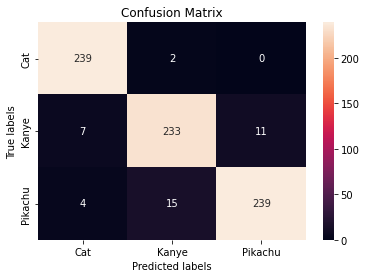

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = confusion_matrix(classes_x.ravel(), val_labels)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Cat', 'Kanye','Pikachu']); ax.yaxis.set_ticklabels(['Cat', 'Kanye','Pikachu']);

# Cloud Deployment

In [24]:
'''I will be using Colab to deploy given I have the M1 MacBook and Tensorflow 
on it is not compatible with Anaconda.

I have made attempts using ngrok both with flask and PyDash which is not working 
due to some Port issues. The code is okay otherwise.'''

import pickle
pickle.dump(model, open('model.pkl','wb'))
model = pickle.load(open('model.pkl','rb'))
# !cp -r '/content/model.pkl' "/content/drive/My Drive"

INFO:tensorflow:Assets written to: ram://50d80bfb-ce18-4930-bbbd-2a73ac6b1986/assets


In [25]:
# Helper function to load image, transform it and return predictions

def deploy_prep(DIR, mod):
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height, 3))
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        DIR,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='categorical',
        shuffle=False) 
    features = model.predict_generator(generator, 1, verbose=True)
    np.save('features_sample.npy', features)
    sample_data = np.load('features_sample.npy')
    class_pred = mod.predict(test_data,verbose=0)
    predict_classes=np.argmax(class_pred)
    prob_pred = class_pred[predict_classes]
    if predict_classes == 0:
        class_guess='CAT'
    elif predict_classes == 1:
        class_guess='KANYE'
    else:
        class_guess='PIKACHU'
    return class_guess, str(round(float(prob_pred)*100,5))

In [26]:
# !mkdir -p /drive/ngrok-ssh
# %cd /drive/ngrok-ssh
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
# !unzip -u ngrok-stable-linux-amd64.zip
# !cp /drive/ngrok-ssh/ngrok /ngrok
# !chmod +x /ngrok

In [27]:
# !/ngrok authtoken 25OUWQGtfU6T5PmJ4ctuiY5d2pw_6LyEP1KvrfTm7dgotLh9c

In [28]:
# !cd '/content/drive/My Drive/'

In [78]:
index = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Upload Image</title>
</head>
<body>

    <div class="container">
      <div class="row">
        <div class="col">

    <h1>Upload Image</h1>
          <hr>

    <form action="/upload-image" method="POST" enctype="multipart/form-data">

    <div class="form-group">
              <label>Select image</label>
              <div class="custom-file">
                <input type="file" class="custom-file-input" name="image"

    id="image">
                <label class="custom-file-label" for="image"></label>
              </div>
            </div>
    <button type="submit" class="btn btn-primary">Upload</button>
    </form>

        </div>
      </div>
    </div>


</body>
</html>
'''

upload = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Upload Image</title>
</head>
<body>

    <div class="container">
      <div class="row">
        <div class="col">

    <h1>Upload Image</h1>
          <hr>

    <form action="/upload-image" method="POST" enctype="multipart/form-data">

    <div class="form-group">
              <label>Select image</label>
              <div class="custom-file">
                <input type="file" class="custom-file-input" name="image"

    id="image">
                <label class="custom-file-label" for="image"></label>
              </div>
            </div>
    <button type="submit" class="btn btn-primary">Upload</button>
    </form>

        </div>
      </div>
    </div>

    <img src="{{ url_for('send_uploaded_file', filename=uploaded_image) }}" />

    <br>
    <br>
    {{ output }}

</body>
</html>
'''
if not os.path.exists("templates"):
    os.mkdir('templates')
    
file1 = open('templates/index.html','w')
file1.write(index)
file1.close()

file2 = open('templates/upload_image.html','w')
file2.write(upload)
file2.close()

In [77]:
!pip install flask-ngrok

from flask import Flask, redirect, jsonify, request, url_for, render_template, flash
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)
app.config["IMAGE_UPLOADS"] = "/content/drive/My Drive/templates/"

@app.route("/")
def home():
    return render_template("index.html")

@app.route('/upload-image', methods=['GET', 'POST'])
def upload_image():
    if request.method == "POST":
        if request.files:
            image = request.files["image"]
            image.save(os.path.join(app.config["IMAGE_UPLOADS"], image.filename))
            # deploy_prep(app.config["IMAGE_UPLOADS"], model)
            return render_template("upload_image.html", uploaded_image=image.filename)
    return render_template("upload_image.html", output = 'I think this is a {} with {} % probability'.format(deploy_prep(app.config["IMAGE_UPLOADS"], model)[0],deploy_prep(app.config["IMAGE_UPLOADS"], model)[1]))

@app.route('/uploads/<filename>')
def send_uploaded_file(filename=''):
    from flask import send_from_directory
    return send_from_directory(app.config["IMAGE_UPLOADS"], filename)

if __name__ == "__main__":
    app.run()

 * Running on http://7065-35-194-173-145.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


t=2022-02-21T15:50:18+0000 lvl=warn msg="failed to open private leg" id=968bcf207637 privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"
t=2022-02-21T15:50:18+0000 lvl=warn msg="failed to open private leg" id=70fb504e3f1c privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"


In [32]:
# import plotly.express as px
# from skimage import io
# img = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Crab_Nebula.jpg/240px-Crab_Nebula.jpg')
# fig = px.imshow(img)
# fig.show()

In [74]:
# !pip install jupyter-dash

import datetime
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

if not os.path.exists("/content/drive/My Drive/images"):
    os.mkdir("/content/drive/My Drive/images")

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Upload(
        id='upload-image',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.Div(id='output-image-upload'),
    # html.Button('Submit', id='submit-val', n_clicks=0)
])

locz = "/content/drive/My Drive/templates/"

def parse_contents(contents, filename, date):
    # print(contents)
    # contents.write_image("/content/drive/My Drive/images/test.png")
    # contents.save(os.path.join(locz, filename))
    return html.Div([
        html.H5(filename),
        html.H6('I think this is a {} with {} % probability'.format("Kanye/Pikachu/Cat","33")),
        html.Img(src=contents),
        html.Hr(),
        # html.Div('Raw Content'),
        html.Pre(contents[0:200] + '...', style={
            'whiteSpace': 'pre-wrap',
            'wordBreak': 'break-all'
        })
    ])

@app.callback(Output('output-image-upload', 'children'),
              Input('upload-image', 'contents'),
              State('upload-image', 'filename'),
              State('upload-image', 'last_modified'))

def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children

# if __name__ == '__main__':
#     app.run_server(debug=True)

In [75]:
app.run_server(mode='external', debug=True)

Dash app running on:


<IPython.core.display.Javascript object>

In [48]:
# ! pip install pyngrok

In [49]:
! ngrok authtoken 25OUWQGtfU6T5PmJ4ctuiY5d2pw_6LyEP1KvrfTm7dgotLh9c

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [50]:
# !sudo apachectl start
# !ngrok http 80

In [51]:
from pyngrok import ngrok

# Open a HTTP tunnel on the default port 80
public_url = ngrok.connect(port = '8050')
public_url

<NgrokTunnel: "http://aa68-35-194-173-145.ngrok.io" -> "http://localhost:80">

# YOLO Attempt

In [52]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0

# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('/content/drive/My Drive/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [53]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/content/drive/My Drive/TEST/Tester/cat.360.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["kanye","pikachu","cat"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
